# GGH Cryptanalysis
A demo of the GGH cryptanalysis by Nguyen. For illustration purposes we limit the dimension of the lattice to 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix
from ggh.signature import generate_keypair, LatticeBasis
from ggh.attack import generate_pairs, gradient_descent, simulate_attack

# Fix seeding for reproducible results
np.random.seed(999)

lattice_dim = 2
pk, sk = generate_keypair(lattice_dim)
print(f"ortho-defect of sk is {sk.ortho_defect}")
display(sk.to_sympy_matrix())
print(f"ortho-defect of pk is {pk.ortho_defect}")
display(pk.to_sympy_matrix())


sample_pairs = generate_pairs(10000, sk)
samples = [(sigma - m) * 2 for (m, sigma) in sample_pairs]

ortho-defect of sk is 1.0003740339937717


Matrix([
[293,  -8],
[  1, 260]])

ortho-defect of pk is 293.0017064796722


Matrix([
[76188, 293],
[    0,   1]])

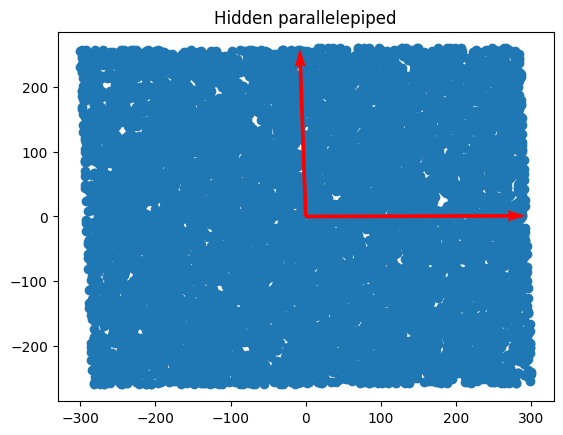

In [2]:
# Visualize the hidden parallelepiped
sample_xs = [sample[0] for sample in samples]
sample_ys = [sample[1] for sample in samples]

hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("Hidden parallelepiped")
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for base_vector in sk.iter_base_vectors():
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(0, 0, x, y, color="red", angles='xy', scale_units='xy', scale=1)

plt.show()

# Estimate the covariance matrix

Given a parallelepiped defined by $\mathcal{P}(V) = \{V\mathbf{x} \mid \mathbf{x} \in [-1, 1]^n \}$, and some uniformly sampled $\mathbf{v} \leftarrow \mathcal{P}(V)$:

$$
\exp[\mathbf{v}^\intercal\mathbf{v}] = V^\intercal V
$$

This means that we can use the samples $\{\mathbf{m}_i - \mathbf{\sigma}_i\}_{i \in S}$ to approximate the convariance matrix

In [3]:
samples_sym = Matrix(np.array(samples).astype(int))
samples_np = np.array(samples)
approx_covariance = samples_np.transpose().dot(samples_np) / samples_np.shape[0] * 3
true_covariance = Matrix(
    sk.to_sympy_matrix() * sk.to_sympy_matrix().transpose()
)

print(f"The estimated covariance is:")
display(Matrix(approx_covariance))
print(f"The true covariance is:")
display(true_covariance)

The estimated covariance is:


Matrix([
[84502.5696, -1843.0716],
[-1843.0716, 67736.5836]])

The true covariance is:


Matrix([
[85913, -1787],
[-1787, 67601]])

# Hypercube transformation

Now that we have approximated the covariance matrix, we can transform the parallelepiped into the hypercube:

1. Compute $G^{-1}$ where $G$ is the approximated covariance matrix
2. Compute $L$ the Cholesky factor of $G^{-1}$ (the unique lower-triangular matrix such that $G^{-1} = LL^\intercal$).
3. Compute $C = VL$ where $V$ is the basis of the hidden parallelepiped

Then:

- $C$ is pairwise orthogonal unit vectors
- If $\mathbf{v}$ is uniformly distributed over the parallelepiped, then $\mathbf{c} = \mathbf{v}L$ is uniformly distributed over the hypercube $\mathcal{P}(C)$

The true hypercube basis is


Matrix([
[ 0.999180701038963, -0.0307690031886879],
[0.0268675999601096,   0.999992603632356]])

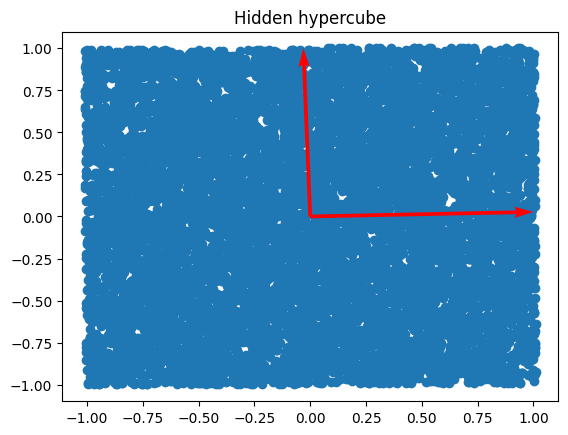

In [4]:
# approx_cholesky = approx_covariance.inv().cholesky(hermitian=False)
approx_cholesky = np.linalg.cholesky(np.linalg.inv(approx_covariance))
true_cholesky = true_covariance.inv().cholesky(hermitian=False)
cube_samples = samples_np.dot(approx_cholesky)
# cube_samples = np.array(cube_samples_sym.evalf()).astype(float)
cube_basis = sk.to_sympy_matrix() * true_cholesky

print("The true hypercube basis is")
display(cube_basis.evalf())
cube_basis = np.array(cube_basis).astype(float)

cube_fig, cube_ax = plt.subplots()
cube_ax.set_title("Hidden hypercube")
cube_ax.scatter(x=cube_samples[:, 0], y=cube_samples[:, 1])
for base_vector in LatticeBasis(cube_basis).iter_base_vectors():
    x, y = base_vector[0], base_vector[1]
    cube_ax.quiver(0, 0, x, y, color="red", angles='xy', scale_units='xy', scale=1)

plt.show()

# Learning the hypercube using gradient descent

The k-th moment of a parallelepipied $\mathcal{P}(V)$ over a vector $\mathbf{w}\in\mathbb{R}^n$ is defined by:

$$
\mathop{\text{mom}}_{V,k}(\mathbf{w}) = E[\langle \mathbf{u}, \mathbf{w}\rangle ^ k]
$$

where $\mathbf{u}$ is uniformly distributed over $\mathcal{P}(V)$

Nguyen showed that the global minimum of the fourth moment $\mathop{\text{mom}}_{V, 4}$ over the unit sphere is achieved at $\pm \mathbf{v}_i$ for $1 \leq i \leq n$ and there are no other local minima.

In other words, we can empirically search for the $\mathbf{w} \in \mathbb{R}^n$ that minimizes the fourth moment, and the result should be a close approximation of one of the basis of the hypercube, which we denote by $\mathbf{c}$.

Since $C = VL$, we can recover the basis of the hidden parallelepiped $\mathbf{v} = \mathbf{c}L^{-1}$

## Empirical computation
We can approximate the k-th moment and its gradient using the samples:

$$
\mathop{\text{mom}}_{V,k}(\mathbf{w}) \approx \frac{1}{n}\sum_{\mathbf{u} \in S} (\mathbf{u}^\intercal\mathbf{w})^k
$$

$$
\frac{\partial}{\partial\mathbf{w}}
\bigg\lbrack
    \mathop{\text{mom}}_{V,k}(\mathbf{w})
\bigg\rbrack
\approx \frac{k}{n}
\sum_{\mathbf{u} \in S} \bigg(
(\mathbf{u}^\intercal\mathbf{w})^{k-1}\mathbf{u}
\bigg)
$$

In [5]:
approx_secret_basis = []
for w_init in np.eye(lattice_dim):
    approx_cube_base = gradient_descent(cube_samples, 0.7, w_init)
    v = np.linalg.inv(approx_cholesky).transpose().dot(approx_cube_base)
    approx_secret_basis.append(np.round(v))
approx_secret_basis = LatticeBasis(np.array(approx_secret_basis).transpose())

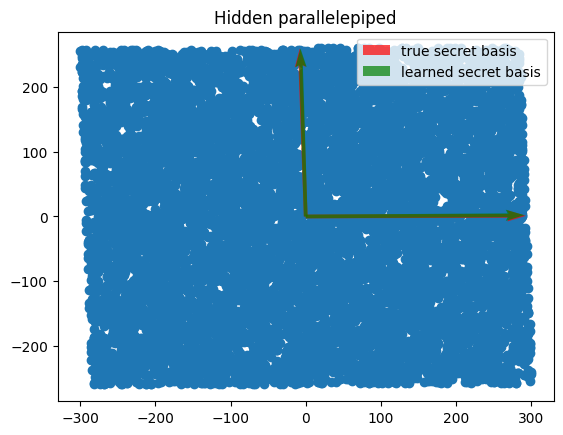

In [6]:
# Visualize the recovered basis against the true basis
hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("Hidden parallelepiped")
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for i, base_vector in enumerate(sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="true secret basis" if i == 0 else None,
        color="red", alpha=0.7
    )
for i, base_vector in enumerate(approx_secret_basis.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="learned secret basis" if i == 0 else None,
        color="green", alpha=0.7
    )

plt.legend()
plt.show()

# Trying the cryptanalysis for higher dimensions


Lattice dimension at n=80, sample size 20000
The distance between true and learned basis is 0.7995133948156343


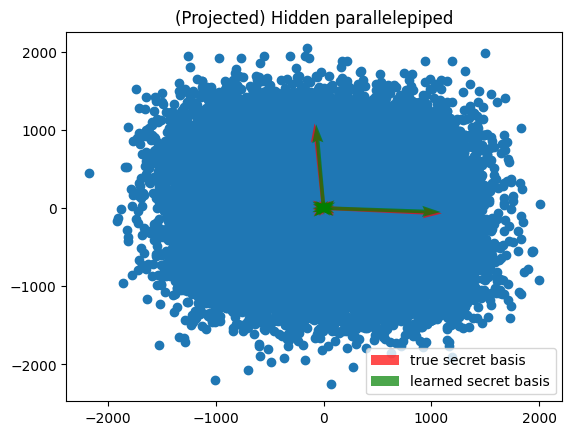

In [12]:
lattice_dim, sample_size = 80, 100000
sk, approx_sk, samples = simulate_attack(lattice_dim, sample_size, 0.7)
print(f"Lattice dimension at n={lattice_dim}, sample size {sample_size}")

# NOTE: For large values of n the basis becomes unreadable, so displaying the
#   basis is commented out
# print(f"True secret basis is:"); display(sk.to_sympy_matrix())
# print(f"Learned secret basis is:"); display(approx_sk.to_sympy_matrix())
print(f"The distance between true and learned basis is {sk.dist(approx_sk)}")

# Visualize the true basis, the approximated basis, and the samples
hpp_fig, hpp_ax = plt.subplots()
hpp_ax.set_title("(Projected) Hidden parallelepiped")
sample_xs = [sample[0] for sample in samples]
sample_ys = [sample[1] for sample in samples]
hpp_ax.scatter(x=sample_xs, y=sample_ys)
for i, base_vector in enumerate(sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="true secret basis" if i == 0 else None,
        color="red", alpha=0.7
    )
for i, base_vector in enumerate(approx_sk.iter_base_vectors()):
    x, y = base_vector[0], base_vector[1]
    hpp_ax.quiver(
        0, 0, x, y, angles='xy', scale_units='xy', scale=1,
        label="learned secret basis" if i == 0 else None,
        color="green", alpha=0.7
    )

plt.legend()
plt.show()